# Runs numerics for mean field model and numerics in finite state space continuous time Markov chain with N listings.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import csv
import time
import itertools
from numpy import random
from operator import itemgetter
import importlib
import multiprocessing as mp
import json

In [3]:
import experiment_helper
import exp_wrapper 

import finite_sim as sim
import finite_sim_wrapper as sim_wrapper

In [4]:
importlib.reload(exp_wrapper)
importlib.reload(experiment_helper)
importlib.reload(sim)
importlib.reload(sim_wrapper)

<module 'finite_sim_wrapper' from '/home/jhays/herding-bias/finite_sim_wrapper.py'>

# Setting parameters model parameters

In [4]:
alpha = 1
epsilon = 1
tau = 1
lams = [ .1, 1, 10]


tsr_ac_al_values = [.5]
cr_a_C = 0.5
lr_a_L = 0.5

tsr_est_types = ['tsr_est_naive', 'tsri_1.0','tsri_2.0']


In [5]:
customer_types = ['c1']
listing_types = ['l']
exp_conditions = ['control', 'treat']
rhos_pre_treat = {'l':1} #adds up to 1
customer_proportions = {'c1':1} #adds up to 1

# used for multiplicative utilities
customer_type_base = {'c1':.315 }
listing_type_base = {'l':1}
exp_condition_base = {'control':1, 'treat':1.25}

vs = {}
#multiplicative -- default
for c in customer_types:
    vs[c] = {}
    vs[c]['treat'] = {}   
    vs[c]['control'] = {}
    for l in listing_types:
        for e in exp_conditions:
            vs[c][e][l] = round(customer_type_base[c]
                                *exp_condition_base[e]
                                *listing_type_base[l],4)

for c in customer_types:
    print("customer", c)
    print("control", vs[c]['control'])
    print("treatment", vs[c]['treat'], "\n")
print('Rhos:', rhos_pre_treat)
print("Customer Proportions:", customer_proportions)

customer c1
control {'l': 0.315}
treatment {'l': 0.3937} 

Rhos: {'l': 1}
Customer Proportions: {'c1': 1}


# Simulations

Setting simulation parameters. Remaining model parameters as defined in mean field parameters.

In [36]:
T_0 = 5
T_1 = 25

# normalizes time horizon by min(lam, tau)
T_start = {lam: T_0/min(lam,tau) for lam in lams}
T_end = {lam: T_1/min(lam,tau) for lam in lams}

varying_time_horizons = True

n_runs = 100
n_listings = 1000

Define choice set type. If 'alpha', customers sample items into consideration set with prob alpha. If 'finite_k', each customer draws a fixed $k$ number of items into their consideration set.

In [37]:
choice_set_type = 'alpha' #customers sample items into consideration set with prob alpha
k = None

In [38]:
params = sim_wrapper.calc_all_params(listing_types, rhos_pre_treat, 
                                     customer_types, customer_proportions, vs, 
                                    alpha, epsilon, tau, lams,
                                    tsr_ac_al_values, cr_a_C, lr_a_L)

## Herding

In [39]:
events_herding = sim_wrapper.run_all_sims(n_runs, n_listings, T_start, T_end, 
                                  choice_set_type, k,
                                 alpha, epsilon, tau, lams,
                                 **params, herding=True)
est_stats_herding = sim_wrapper.calc_all_ests_stats("sample", T_start, T_end, 
                                            n_listings, tau=tau, 
                                            tsr_est_types=tsr_est_types,
                                            events=events_herding, 
                                            varying_time_horizons=varying_time_horizons,
                                            **params
                                           )

lambda= 0.1
Time elapsed:  6883.96
lambda= 1
Time elapsed:  5925.33
lambda= 10


Process ForkPoolWorker-1189:
Process ForkPoolWorker-1212:
Process ForkPoolWorker-1196:
Process ForkPoolWorker-1208:
Process ForkPoolWorker-1202:
Process ForkPoolWorker-1174:
Process ForkPoolWorker-1197:
Process ForkPoolWorker-1204:
Process ForkPoolWorker-1215:
Process ForkPoolWorker-1198:
Process ForkPoolWorker-1171:
Process ForkPoolWorker-1195:
Process ForkPoolWorker-1191:
Process ForkPoolWorker-1201:
Process ForkPoolWorker-1192:
Process ForkPoolWorker-1213:
Process ForkPoolWorker-1190:
Process ForkPoolWorker-1207:
Process ForkPoolWorker-1193:
Process ForkPoolWorker-1179:
Process ForkPoolWorker-1211:
Process ForkPoolWorker-1214:
Traceback (most recent call last):
Process ForkPoolWorker-1180:
Process ForkPoolWorker-1194:
Process ForkPoolWorker-1181:
Process ForkPoolWorker-1178:
Process ForkPoolWorker-1209:
Traceback (most recent call last):
Process ForkPoolWorker-1184:
Process ForkPoolWorker-1199:
Process ForkPoolWorker-1176:
Process ForkPoolWorker-1188:
Process ForkPoolWorker-1187:
Pr

KeyboardInterrupt: 

  File "/usr/lib64/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call 

  File "/usr/lib64/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib64/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib64/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib64/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/usr/lib64/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/jhays/herding-bias/finite_sim.py", line 188, in run_mc_listing_ids
    thetas, gammas, tau, lam_gammas)
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib64/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib64/python3.6/multiprocessing/q

  File "/usr/lib64/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/jhays/herding-bias/finite_sim.py", line 197, in run_mc_listing_ids
    alpha, epsilon)
  File "/usr/lib64/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/home/jhays/herding-bias/finite_sim.py", line 188, in run_mc_listing_ids
    thetas, gammas, tau, lam_gammas)
  File "/home/jhays/.local/lib/python3.6/site-packages/pandas/core/indexing.py", line 670, in __setitem__
    iloc._setitem_with_indexer(indexer, value)
  File "/usr/lib64/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/usr/lib64/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/jhays/herding-bias/finite_sim.py", line 136, in customer_choice
    choice = customer_choice_alpha(n, s_t, thetas, gamma, vs_gamma

  File "/home/jhays/herding-bias/finite_sim.py", line 204, in run_mc_listing_ids
    available_set = listings_df[(listings_df['type']==choice)]
  File "/home/jhays/.local/lib/python3.6/site-packages/pandas/core/series.py", line 540, in _values
    @property
  File "/usr/lib64/python3.6/random.py", line 233, in _randbelow
    r = getrandbits(k)          # 0 <= r < 2**k
  File "/home/jhays/.local/lib/python3.6/site-packages/pandas/core/frame.py", line 2951, in _getitem_bool_array
    return self._take_with_is_copy(indexer, axis=0)
  File "/home/jhays/.local/lib/python3.6/site-packages/pandas/core/internals/managers.py", line 1457, in take
    new_axis=new_labels, indexer=indexer, axis=axis, allow_dups=True
  File "<__array_function__ internals>", line 6, in unique
  File "/home/jhays/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py", line 261, in unique
    ret = _unique1d(ar, return_index, return_inverse, return_counts)
KeyboardInterrupt
  File "/home/jhays/.local/lib/python3

  File "/home/jhays/.local/lib/python3.6/site-packages/pandas/core/indexes/base.py", line 742, in _assert_take_fillable
    taken = values.take(indices)
KeyboardInterrupt
  File "<__array_function__ internals>", line 6, in prod
KeyboardInterrupt
KeyboardInterrupt
  File "/home/jhays/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py", line 3000, in prod
    keepdims=keepdims, initial=initial, where=where)
  File "/home/jhays/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py", line 71, in _wrapreduction
    passkwargs = {k: v for k, v in kwargs.items()
  File "/home/jhays/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py", line 71, in <dictcomp>
    passkwargs = {k: v for k, v in kwargs.items()
KeyboardInterrupt


In [ ]:
est_stats_herding = est_stats_herding.rename({'cr':"Customer-Side", 'lr':"Service-Side",
                            'tsri_2.0':'TSRI-2', 'tsri_1.0':'TSRI-1',
                             'tsr_est_naive':"TSR-Naive"
                            })

## Competition

In [ ]:
events_competition = sim_wrapper.run_all_sims(n_runs, n_listings, T_start, T_end, 
                                  choice_set_type, k,
                                 alpha, epsilon, tau, lams,
                                 **params)
est_stats_competition = sim_wrapper.calc_all_ests_stats("sample", T_start, T_end, 
                                            n_listings, tau=tau, 
                                            tsr_est_types=tsr_est_types,
                                            events=events_competition, 
                                            varying_time_horizons=varying_time_horizons,
                                            **params
                                           )

In [ ]:
est_stats_competition = est_stats_competition.rename({'cr':"Customer-Side", 'lr':"Service-Side",
                            'tsri_2.0':'TSRI-2', 'tsri_1.0':'TSRI-1',
                             'tsr_est_naive':"TSR-Naive"
                            })

# Visualizations

## Visualizations: Herding

In [36]:
rgb_dict = {'cr': (0, 114, 178), 'lr':(255, 127, 14),
          'tsrn':(0, 158, 115), 'tsri1':(240, 228, 66), 
            'tsri2':(204, 121, 167),
          'cluster':(86, 180, 233)}

rgb_0_1_array = np.array(list(rgb_dict.values()))/255

In [37]:
est_stats_herding = pd.read_csv("sample_total_stats_herding.csv", index_col=["estimator_type", "lambda"])

est_stats_herding = est_stats_herding.rename({'cr':"Customer-Side", 'lr':"Product-Side",
                            'tsri_2.0':'TSRI-2', 'tsri_1.0':'TSRI-1',
                             'tsr_est_naive':"TSR-Naive"
                            })

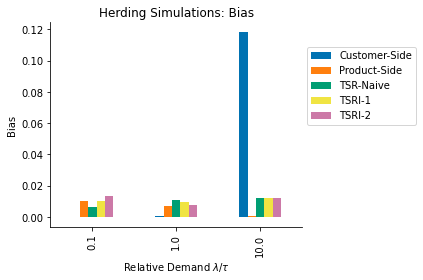

In [38]:
stat = 'bias'

(est_stats_herding
 .unstack(level=0)[stat]
 .plot(kind='bar', color=rgb_0_1_array))

#plt.yscale('log')
plt.title("Herding Simulations: Bias")
plt.legend(loc=[1.02,0.5])
plt.ylabel("Bias")
plt.xlabel("Relative user arrival rate $\lambda/\\tau$")
plt.tight_layout()
sns.despine()
plt.savefig("herding_bias.svg")

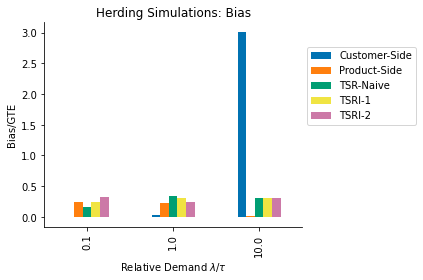

In [39]:
stat = 'bias_over_GTE'

(est_stats_herding
 .unstack(level=0)[stat]
 .plot(kind='bar', color=rgb_0_1_array))

#plt.yscale('log')
plt.title("Herding Simulations: Bias")
plt.legend(loc=[1.02,0.5])
plt.ylabel("Bias/GTE")
plt.xlabel("Relative user arrival rate $\lambda/\\tau$")
plt.tight_layout()
sns.despine()
plt.savefig("herding_bias.svg")

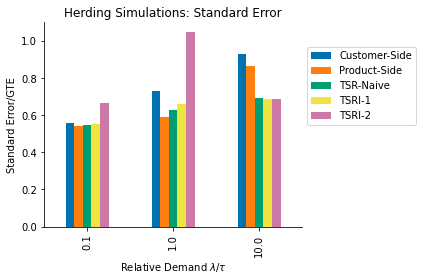

In [40]:
stat = 'std_over_GTE'

(est_stats_herding
 .unstack(level=0)[stat]
 .plot(kind='bar',color=rgb_0_1_array))


plt.xlabel("Relative user arrival rate $\lambda/\\tau$")
plt.title("Herding Simulations: Standard Error")
plt.legend(loc=[1.02,0.5])
plt.ylabel("Standard Error/GTE")
plt.tight_layout()
sns.despine()


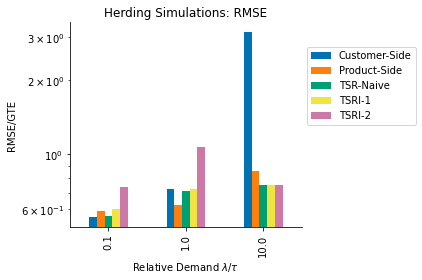

In [41]:
stat = 'rmse_over_GTE'

(est_stats_herding
 .unstack(level=0)[stat]
 .plot(kind='bar', color=rgb_0_1_array))


plt.yscale('log')
plt.xlabel("Relative user arrival rate $\lambda/\\tau$")
plt.title("Herding Simulations: RMSE")
plt.legend(loc=[1.02,0.5])
plt.ylabel("RMSE/GTE")
plt.tight_layout()
sns.despine()

## Visualizations: competition

In [42]:
est_stats_competition = pd.read_csv("sample_total_stats_competition.csv", index_col=["estimator_type", "lambda"])

est_stats_competition = est_stats_herding.rename({'cr':"Customer-Side", 'lr':"Service-Side",
                            'tsri_2.0':'TSRI-2', 'tsri_1.0':'TSRI-1',
                             'tsr_est_naive':"TSR-Naive"
                            })

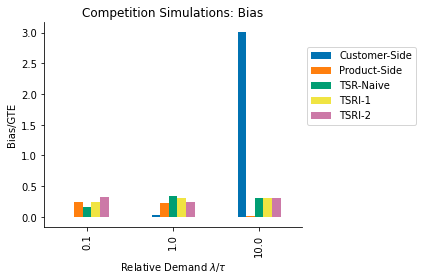

In [43]:
stat = 'bias_over_GTE'

(est_stats_competition
 .unstack(level=0)[stat]
 .plot(kind='bar', color=rgb_0_1_array))

#plt.yscale('log')
plt.xlabel("Relative user arrival rate $\lambda/\\tau$")
plt.title("Competition Simulations: Bias")
plt.legend(loc=[1.02,0.5])
plt.ylabel("Bias/GTE")
plt.tight_layout()
sns.despine()
plt.savefig("competition_bias.svg")

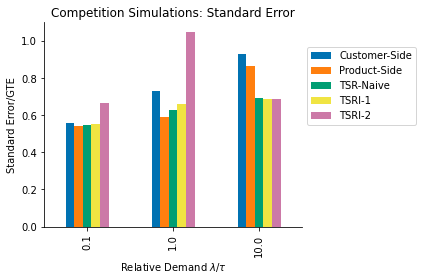

In [44]:
stat = 'std_over_GTE'

(est_stats_competition
 .unstack(level=0)[stat]
 .plot(kind='bar',color=rgb_0_1_array))


plt.xlabel("Relative user arrival rate $\lambda/\\tau$")
plt.title("Competition Simulations: Standard Error")
plt.legend(loc=[1.02,0.5])
plt.ylabel("Standard Error/GTE")
plt.tight_layout()
sns.despine()


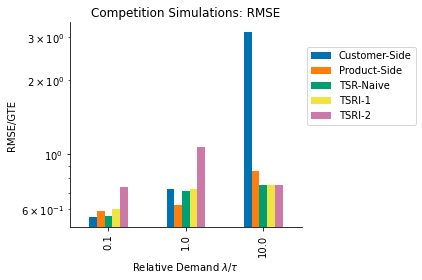

In [45]:
stat = 'rmse_over_GTE'

(est_stats_competition
 .unstack(level=0)[stat]
 .plot(kind='bar', color=rgb_0_1_array))


plt.yscale('log')
plt.xlabel("Relative user arrival rate $\lambda/\\tau$")
plt.title("Competition Simulations: RMSE")
plt.legend(loc=[1.02,0.5])
plt.ylabel("RMSE/GTE")
plt.tight_layout()
sns.despine()